In [19]:
%matplotlib inline
import warnings
## scipy gives a waring when reading wav file
warnings.filterwarnings('ignore')

import scipy as sp
import scipy.io.wavfile
import scipy.signal
import numpy as np
from matplotlib import pyplot as plt

## Util functions

def todB(array):
    mean = np.mean(array)
    return 10 * np.log10(array / mean)

def plotSpectrogram(to_plot, yticks = np.array([]), cmap = plt.cm.gist_heat, subplot=111, _fig=False, fig_size=(15,7)):
    if (_fig == False):
        fig = plt.figure(figsize=fig_size)
    else:
        fig = _fig
    ax = fig.add_subplot(subplot)
    plt.imshow(to_plot, cmap=cmap)
    ax.set_aspect('auto')

    ## making pretty
    ax.set_ylim(ax.get_ylim()[::-1]) ## reversing axis
    plt.title("Spectrogram in the human hearing range")
    plt.xlabel("time (s)")
    plt.ylabel("frequency (Hz)")
    num_labels = 10
    xpoints = np.arange(to_plot.shape[1], step=int(to_plot.shape[1]/num_labels))
    plt.xticks(xpoints, np.round(t_points[xpoints], 1))
    if (yticks.size > 0):
        ypoints = np.arange(to_plot.shape[0], step=int(to_plot.shape[0]/num_labels))
        plt.yticks(ypoints, yticks[ypoints])
    plt.colorbar(orientation='vertical')
    return fig

def pol2cart(theta, rho):
    x = rho * np.cos(theta)
    y = rho * np.sin(theta)
    return x, y

def cartesian_coord(*arrays):
    grid = np.meshgrid(*arrays)        
    coord_list = [entry.ravel() for entry in grid]
    points = np.vstack(coord_list).T
    return points

In [3]:
sample_rate, wav_data = scipy.io.wavfile.read("audio-files/kombucha.wav")
# sample_rate, wav_data = sp.io.wavfile.read("audio-files/radiolab_crispr.wav")
# sample_rate, wav_data = sp.io.wavfile.read("relief.wav")

## taking just one channel
mono_data = wav_data[:, 1]
audio_data = mono_data

start_point = 10 * sample_rate
end_point = 10 * sample_rate + start_point # in seconds
audio_data = audio_data[start_point:end_point]

print(len(mono_data), end_point)
    
segment_length = int(sample_rate/8)
overlap = int(segment_length / 2)
freq_points, t_points, spectrogram = scipy.signal.spectrogram(audio_data, nperseg=segment_length, fs=sample_rate,
                                  noverlap=overlap, mode="psd", nfft=sample_rate)

## just the human hearing range
spectrogram = spectrogram[0:1000, :]

919485 882000


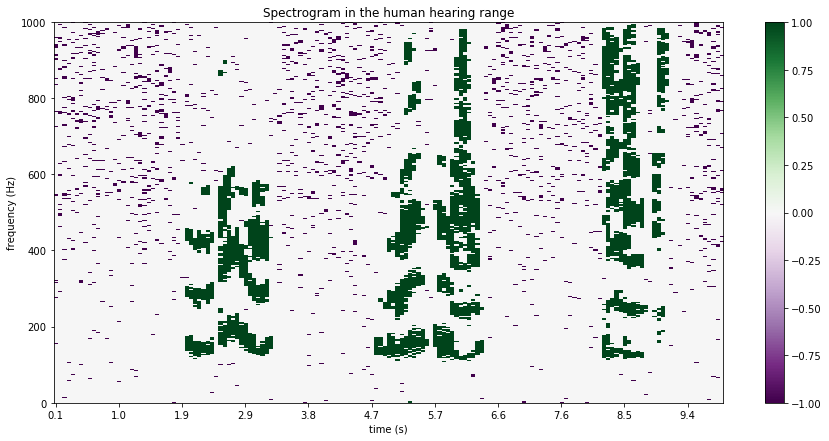

In [6]:
from matplotlib import pyplot as plt

bound_width = 1.5

flat_values = np.ndarray.flatten(spectrogram)
flat_db_values = todB(flat_values)

## some basic stats calculations
mean = np.mean(flat_db_values)
sd = np.std(flat_db_values)
activation_bounds = (mean - bound_width * sd, mean + bound_width * sd)

##
# so which spectrogram segments are outside the bounds?
##

s_db = todB(spectrogram)
shl = np.zeros(spectrogram.shape)
shl[s_db < activation_bounds[0]] = -1
shl[s_db > activation_bounds[1]] = 1

f = plotSpectrogram(shl, cmap=plt.cm.PRGn)

max 1.0
min -0.568071047176


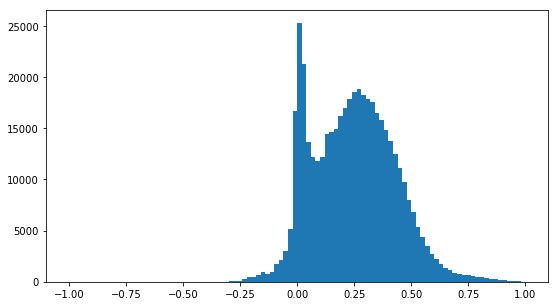

In [70]:
##
# Onto actual pattern recognition!
##

# only one half of the correlation matrix is needed, the other is identical.
# the diagonal is self correlation, which is omitted
corr = np.tril(np.ma.corrcoef(shl), k=-1)
# corr[]
corr_flat = np.ndarray.flatten(corr)
corr_nz = corr_flat[corr_flat != 0]
print("max", np.max(corr))
print("min", np.min(corr))

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
ax.hist(corr_nz, bins=100, range=(-1,1))
plt.show()

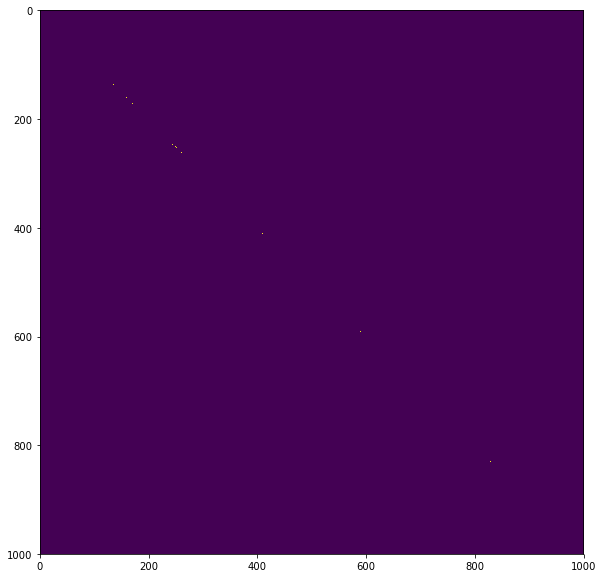

In [75]:
fig = plt.figure(figsize=(20,10))
corr_high = corr
corr_high[corr < 0.90] = 0
plt.imshow(corr_high)

In [176]:
# lets figure out using numerical methods the main edge types in the spectrogram

# the angles and jump magnitudes which we will study
angle_step = np.pi / 8
angles = np.arange(np.pi * 2, step=angle_step)
jump_mag = np.arange(300, step=5) + 5
test_vectors = cartesian_coord(angles, jump_mag)

# locations which are possible starting locations (high activation)
test_start_locations = np.array([pos for pos, val in np.ndenumerate(shl) if val > 0 ])
# print(test_start_locations)
np.random.shuffle(test_start_locations)
tests_per_vector = 200
tr_buff = np.empty((test_vectors.shape[0], 2))

for i in np.arange(test_vectors.shape[0]):
    v = test_vectors[i]
    s_pos_rint = np.random.randint(0, test_start_locations.shape[0] - tests_per_vector)
    s_pos = test_start_locations[s_pos_rint : s_pos_rint + tests_per_vector]
    r = np.random.rand(tests_per_vector, test_vectors.shape[1])
    vr = r
    # the angle can take any value between angles of neighbouring test vectors 
    vr[:, 0] = (vr[:, 0] - 0.5)* (angle_step) + v[0]
    vr[:, 1] = vr[:, 1] * v[1]

    coord_th = np.rint([pol2cart(th, mag) for th, mag in vr]).astype(int)
    coord = (coord_th + s_pos)
    # making sure the index is not out of bounds
    coord = coord[(coord[:,0] < shl.shape[0]) & (coord[:,0] >= 0) & (coord[:,1] < shl.shape[1]) & (coord[:,1] >= 0)]
    coord = coord.T

    res = shl[coord[0], coord[1]]
    res_sum = np.sum(np.abs(res))
    tr_buff[i] = np.array([res_sum, int(res_sum / coord.shape[1] * 100)])

    
print("Test results")
np.set_printoptions(precision=2, suppress=True)
test_results = np.concatenate((test_vectors, tr_buff), axis=1)
test_results[:,0] = np.round(test_results[:,0] / np.pi, 2)
print(test_results[0:50])

Test results
[[   0.      5.    172.     86.  ]
 [   0.12    5.    140.     70.  ]
 [   0.25    5.    109.     54.  ]
 [   0.38    5.    105.     52.  ]
 [   0.5     5.     98.     49.  ]
 [   0.62    5.    105.     52.  ]
 [   0.75    5.    122.     61.  ]
 [   0.88    5.    141.     70.  ]
 [   1.      5.    168.     84.  ]
 [   1.12    5.    137.     68.  ]
 [   1.25    5.    116.     57.  ]
 [   1.37    5.     96.     48.  ]
 [   1.5     5.     89.     44.  ]
 [   1.63    5.     89.     44.  ]
 [   1.75    5.    129.     64.  ]
 [   1.87    5.    152.     76.  ]
 [   0.     10.    151.     75.  ]
 [   0.12   10.    103.     51.  ]
 [   0.25   10.     79.     39.  ]
 [   0.38   10.     69.     34.  ]
 [   0.5    10.     70.     35.  ]
 [   0.62   10.     65.     32.  ]
 [   0.75   10.     88.     44.  ]
 [   0.88   10.     91.     45.  ]
 [   1.     10.    151.     75.  ]
 [   1.12   10.     96.     48.  ]
 [   1.25   10.     93.     46.  ]
 [   1.37   10.     64.     32.  ]
 [   1.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
